Python for NLP: Multi-label Text Classification with Keras

Multi-label Text Classification Model with Multiple Output Layer

https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/ (english)

https://maelfabien.github.io/machinelearning/NLPfr/#7-embedding-par-mot (french - spacy)

Import data and libraries

In [1]:
import pandas as pd

#'Unnamed: 0' 'lemmes' 'pos'
X_train = pd.read_csv("../challenge_dataset/X_train_clean.csv").drop(columns='Unnamed: 0')

#'Id', 'category_1', 'category_2', 'category_3', 'category_4'
Y_train = pd.read_csv("../challenge_dataset/y_train.csv",sep=";").drop(columns="Id")

#'Id ', 'Caption'
#X_test = pd.read_csv("../challenge_dataset/X_test.csv",sep=';').drop(columns='Id ')

In [2]:
#X_test.columns
Y_train.columns

Index(['category_1', 'category_2', 'category_3', 'category_4'], dtype='object')

Necessary imports

In [3]:
#pip install tensorflow

from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate

import numpy as np
import re

import matplotlib.pyplot as plt

Shape and header

In [4]:
print(X_train.shape)

X_train.head()

(485, 2)


,lemmes,pos
0,"['mourir', 'heure', 'plus', 'revoir', 'petit',...","['VERB', 'NOUN', 'ADV', 'VERB', 'ADJ', 'NOUN']"
1,"['maladie', 'conséquence', 'jeune', 'génératio...","['NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN'..."
2,"['sortir', 'mal', 'loger']","['VERB', 'ADV', 'VERB']"
3,"['inquiétude', 'santé', 'proche', 'plus', 'fra...","['NOUN', 'ADJ', 'ADJ', 'ADV', 'ADJ', 'NOUN', '..."
4,"['bien', 'entendre', 'contracter', 'maladie']","['ADV', 'VERB', 'VERB', 'NOUN']"


Repartition of categories among training dataset

<AxesSubplot: >

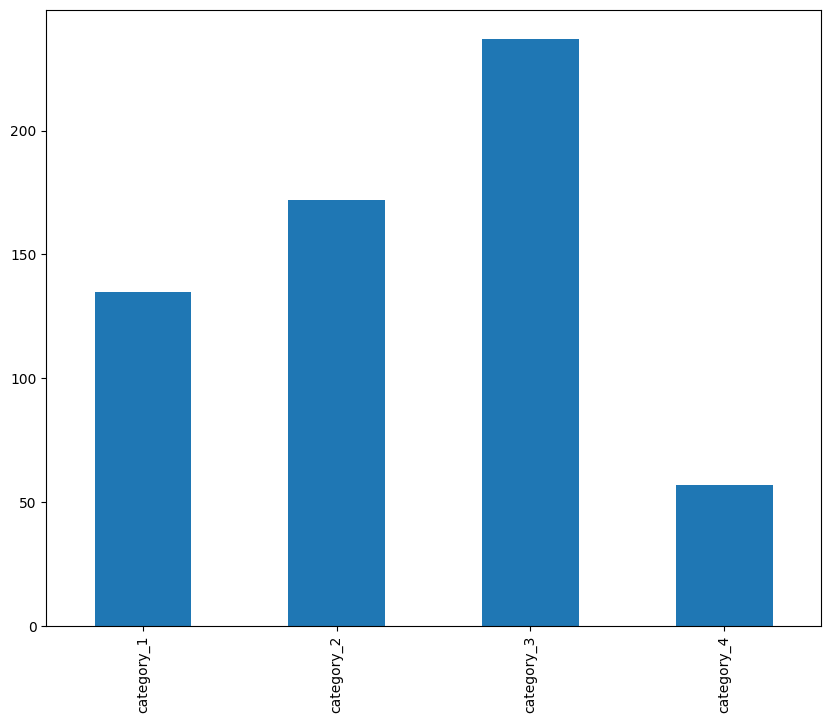

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Y_train.sum(axis=0).plot.bar()

Creating Multi-label Text Classification Models

Multi-label Text Classification Model with Multiple Output Layer

Pre-processing text

In [6]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Zéèàùï]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
X_train_cleaned = []

for sentences in X_train['lemmes']:
    X_train_cleaned.append(preprocess_text(sentences))

X_train_cleaned = pd.DataFrame(X_train_cleaned, columns=['values'])

print(X_train_cleaned)

#print(X_train_cleaned)

                                                values
0               mourir heure plus revoir petit enfant 
1     maladie conséquence jeune génération voir sit...
2                                    sortir mal loger 
3     inquiétude santé proche plus fragile femme ba...
4                    bien entendre contracter maladie 
..                                                 ...
480                                 forme grave civid 
481   inquiétude retrouver liberté action total lim...
482   incertitude lequel plus voir petit fils jusqu...
483   inquiétude normal face épidémie crainte voir ...
484                                respecter barrière 

[485 rows x 1 columns]


Training 80% testing 20%

In [8]:
import tensorflow as tf

In [9]:
X = X_train_cleaned['values']
Y = Y_train

X_train_full=X
Y_train_full=Y

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#X_train = tf.convert_to_tensor(X_train, dtype=object)
#X_test = tf.convert_to_tensor(X_test, dtype=object)
#y_train = tf.convert_to_tensor(y_train, dtype=object)
#y_test = tf.convert_to_tensor(y_test, dtype=object)

In [10]:
#'category_1', 'category_2', 'category_3', 'category_4'

# First output
y1_train = y_train[['category_1']].values
y1_train_full = Y_train_full[['category_1']].values
y1_test =  y_test[['category_1']].values

# Second output
y2_train = y_train[['category_2']].values
y2_train_full = Y_train_full[['category_2']].values
y2_test =  y_test[['category_2']].values

# Third output
y3_train = y_train[['category_3']].values
y3_train_full = Y_train_full[['category_3']].values
y3_test =  y_test[['category_3']].values

# Fourth output
y4_train = y_train[['category_4']].values
y4_train_full = Y_train_full[['category_4']].values
y4_test =  y_test[['category_4']].values

Word embedding

In [11]:
#launch once or relaunch previous cell

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train_full = tokenizer.texts_to_sequences(X_train_full)
X_test = tokenizer.texts_to_sequences(X_test)

#print(X_train_cleaned)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_train_full = pad_sequences(X_train_full, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#print(X_train_cleaned)

Word embedding (french)

https://www.cs.cmu.edu/~afm/projects/multilingual_embeddings.html

In [12]:
from numpy import array, asarray, zeros

In [13]:
embeddings_dictionary = dict()

glove_file = open('../resources/multilingual_embeddings.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 300))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [14]:
#print(embedding_matrix)

NN model

In [15]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(32)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Summary of the NN

In [16]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 300)     462000      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 32)           42624       ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 1)            33          ['lstm[0][0]']                   
                                                                                              

Architecture of the NN

In [17]:
from keras.utils import plot_model

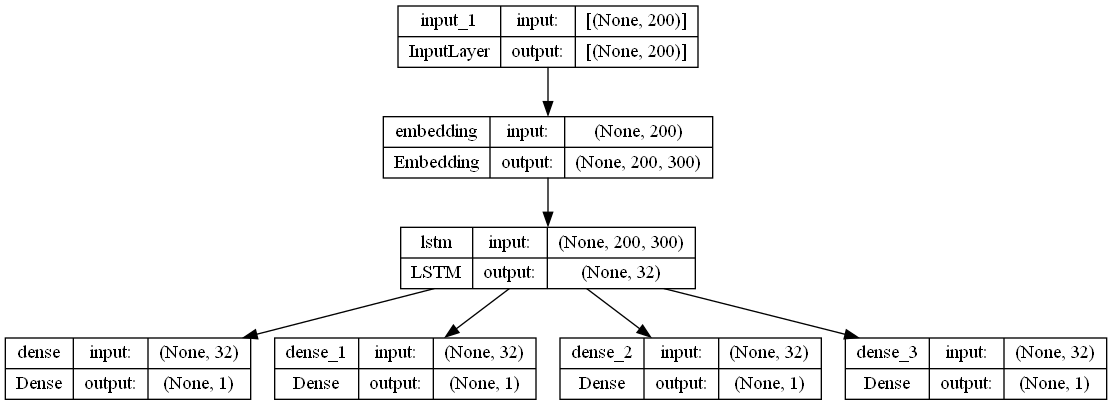

In [18]:
#pip install pydot
#https://graphviz.gitlab.io/download/

plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Train model

In [19]:
#history = model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2)

history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train], batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
3/3 [==============================] - 5s 587ms/step - loss: 2.7697 - dense_loss: 0.6921 - dense_1_loss: 0.6929 - dense_2_loss: 0.6932 - dense_3_loss: 0.6915 - dense_acc: 0.7484 - dense_1_acc: 0.6258 - dense_2_acc: 0.4968 - dense_3_acc: 0.8935 - val_loss: 2.7618 - val_dense_loss: 0.6901 - val_dense_1_loss: 0.6917 - val_dense_2_loss: 0.6927 - val_dense_3_loss: 0.6873 - val_dense_acc: 0.6923 - val_dense_1_acc: 0.6667 - val_dense_2_acc: 0.5897 - val_dense_3_acc: 0.8462
Epoch 2/10
3/3 [==============================] - 1s 182ms/step - loss: 2.7579 - dense_loss: 0.6883 - dense_1_loss: 0.6919 - dense_2_loss: 0.6932 - dense_3_loss: 0.6845 - dense_acc: 0.7484 - dense_1_acc: 0.6258 - dense_2_acc: 0.4968 - dense_3_acc: 0.8935 - val_loss: 2.7499 - val_dense_loss: 0.6868 - val_dense_1_loss: 0.6903 - val_dense_2_loss: 0.6926 - val_dense_3_loss: 0.6802 - val_dense_acc: 0.6923 - val_dense_1_acc: 0.6667 - val_dense_2_acc: 0.5897 - val_dense_3_acc: 0.8462
Epoch 3/10
3/3 [====================

Evaluate model

In [20]:
#score = model.evaluate(X_test, y_test, verbose=1)
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

4/4 [==============================] - 0s 26ms/step - loss: 2.4127 - dense_loss: 0.7096 - dense_1_loss: 0.6195 - dense_2_loss: 0.7076 - dense_3_loss: 0.3761 - dense_acc: 0.6598 - dense_1_acc: 0.6907 - dense_2_acc: 0.4948 - dense_3_acc: 0.8763
Test Score: 2.412691354751587
Test Accuracy: 0.7095550298690796


Graphs of the model

In [21]:
import matplotlib.pyplot as plt

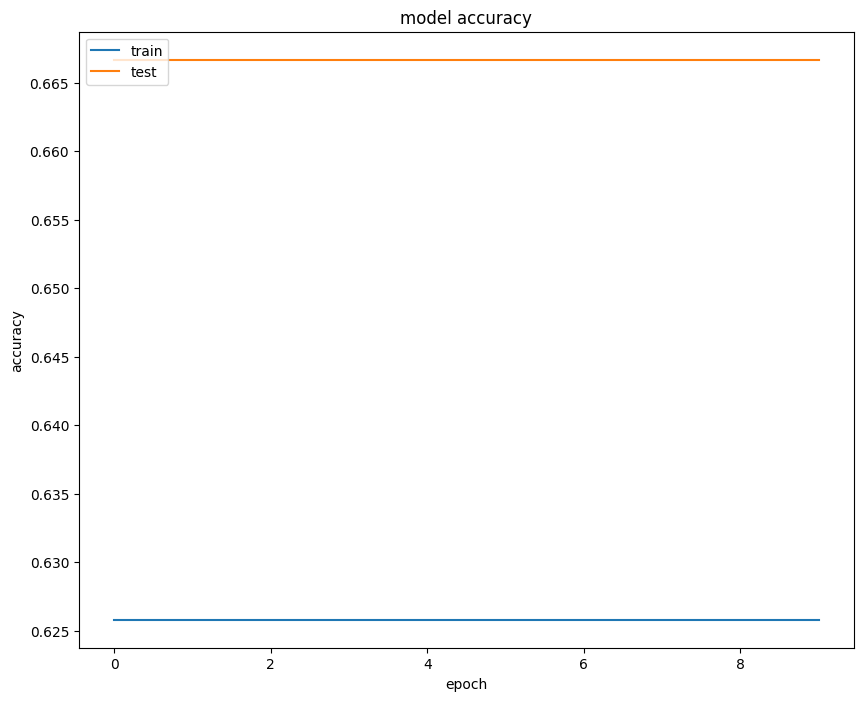

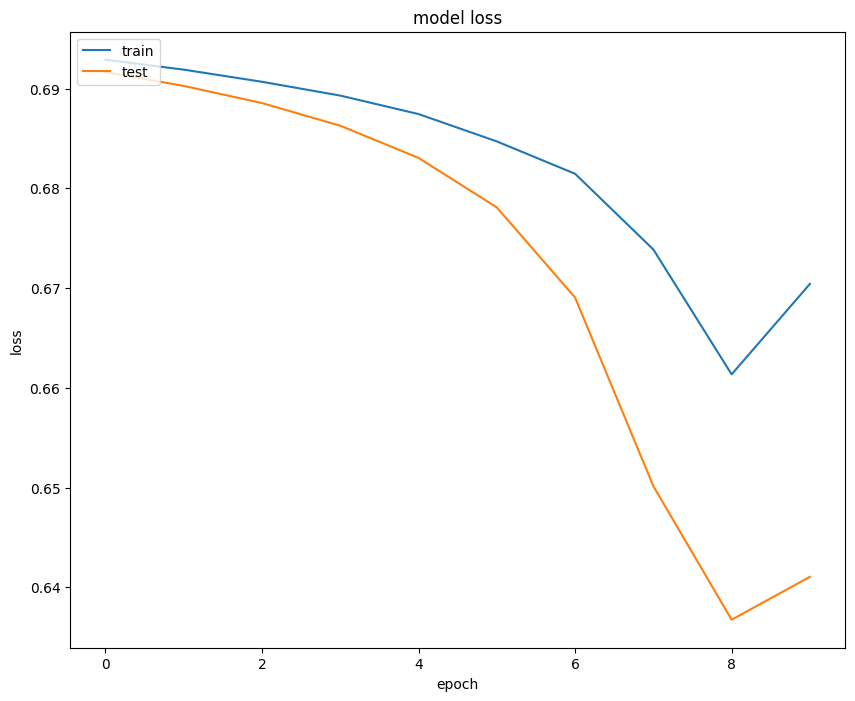

In [22]:
#print(history.history)

plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Predictions

Model on all train data

In [23]:
input_1_full = Input(shape=(maxlen,))
embedding_layer_full = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_1_full)
LSTM_Layer1_full = LSTM(32)(embedding_layer_full)

output1_full = Dense(1, activation='sigmoid')(LSTM_Layer1_full)
output2_full = Dense(1, activation='sigmoid')(LSTM_Layer1_full)
output3_full = Dense(1, activation='sigmoid')(LSTM_Layer1_full)
output4_full = Dense(1, activation='sigmoid')(LSTM_Layer1_full)

model_full = Model(inputs=input_1_full, outputs=[output1_full, output2_full, output3_full, output4_full])
model_full.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [24]:
print(model_full.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 300)     462000      ['input_2[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 32)           42624       ['embedding_1[0][0]']            
                                                                                                  
 dense_4 (Dense)                (None, 1)            33          ['lstm_1[0][0]']                 
                                                                                            

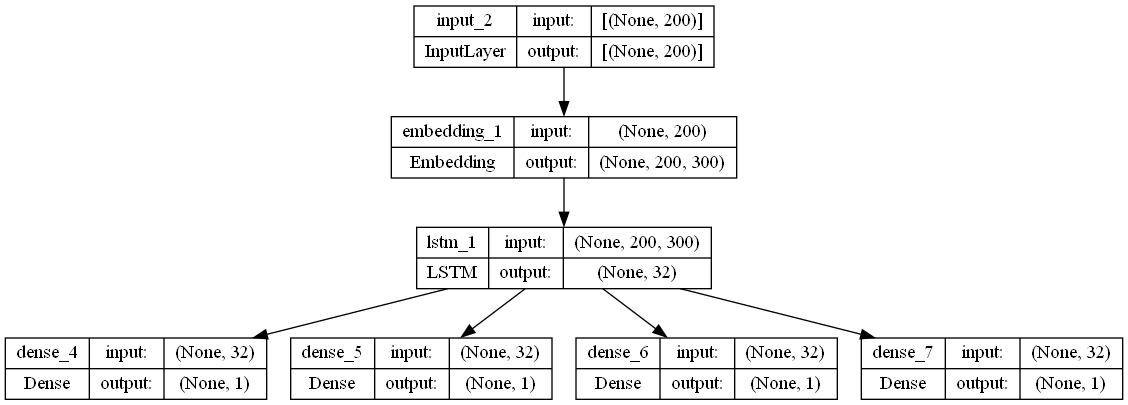

In [25]:
plot_model(model_full, to_file='model_full_plot4a.png', show_shapes=True, show_layer_names=True)

In [26]:
#print(y1_train_full)

history_full = model_full.fit(x=X_train_full, y=[y1_train_full, y2_train_full, y3_train_full, y4_train_full], batch_size=128, epochs=10, verbose=1, validation_split=0)

Epoch 1/10
4/4 [==============================] - 5s 147ms/step - loss: 2.7656 - dense_4_loss: 0.6912 - dense_5_loss: 0.6922 - dense_6_loss: 0.6932 - dense_7_loss: 0.6891 - dense_4_acc: 0.7216 - dense_5_acc: 0.6454 - dense_6_acc: 0.5113 - dense_7_acc: 0.8825
Epoch 2/10
4/4 [==============================] - 1s 142ms/step - loss: 2.7434 - dense_4_loss: 0.6851 - dense_5_loss: 0.6885 - dense_6_loss: 0.6930 - dense_7_loss: 0.6768 - dense_4_acc: 0.7216 - dense_5_acc: 0.6454 - dense_6_acc: 0.5113 - dense_7_acc: 0.8825
Epoch 3/10
4/4 [==============================] - 1s 141ms/step - loss: 2.7126 - dense_4_loss: 0.6763 - dense_5_loss: 0.6840 - dense_6_loss: 0.6930 - dense_7_loss: 0.6593 - dense_4_acc: 0.7216 - dense_5_acc: 0.6454 - dense_6_acc: 0.5113 - dense_7_acc: 0.8825
Epoch 4/10
4/4 [==============================] - 1s 144ms/step - loss: 2.6664 - dense_4_loss: 0.6637 - dense_5_loss: 0.6771 - dense_6_loss: 0.6929 - dense_7_loss: 0.6327 - dense_4_acc: 0.7216 - dense_5_acc: 0.6454 - dense_

In [27]:
#'Id ', 'Caption'

X_test_to_predict = pd.read_csv("../challenge_dataset/X_test.csv",sep=';').drop(columns='Id ')
#X_test_to_predict.columns

In [31]:
Y_predicted_test = model_full.predict(x=X_test_to_predict, batch_size=32, verbose=1, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

UnimplementedError: Graph execution error:

Detected at node 'model_1/Cast' defined at (most recent call last):
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once
      handle._run()
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Perlimpinpin\AppData\Local\Temp\ipykernel_16916\1775587292.py", line 1, in <module>
      Y_predicted_test = model_full.predict(X_test_to_predict)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 650, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "c:\Users\Perlimpinpin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 762, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model_1/Cast'
Cast string to float is not supported
	 [[{{node model_1/Cast}}]] [Op:__inference_predict_function_14170]